# Análisis de texto (text mining) con Python

https://www.cienciadedatos.net/documentos/py25-text-mining-python.html

## Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos

In [14]:
# Lectura de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('Número de tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('Número de tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('Número de tweets @elonmusk: ' + str(tweets_elon.shape[0]))

Número de tweets @BillGates: 2087
Número de tweets @mayoredlee: 2447
Número de tweets @elonmusk: 2678


In [15]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6


## Distribución temporal de los tweets

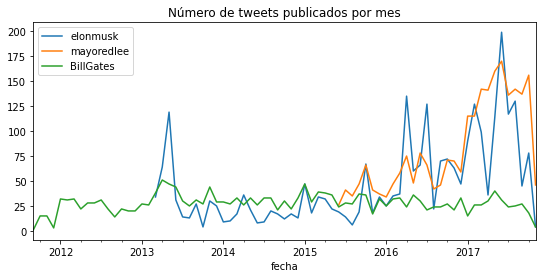

In [16]:
# Distribución temporal de los tweets
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend();

## Limpieza y Tokenización

El proceso de limpieza de texto, dentro del ámbito de text mining, consiste en eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido. No existe una única forma de hacerlo, depende en gran medida de la finalidad del análisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuación. En este ejercicio, se procede a eliminar: patrones no informativos (urls de páginas web), signos de puntuación, etiquetas HTML, caracteres sueltos y números.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por unidad el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

Existen múltiples librerías que automatizan en gran medida la limpieza y tokenización de texto, por ejemplo, la clase `feature_extraction.text.CountVectorizer` de Scikit Learn, nltk.tokenize o spaCy. A pesar de ello, para este ejemplo, se define una función que, si bien está menos optimizada, tiene la ventaja de poder adaptarse fácilmente dependiendo del tipo de texto analizado.

In [17]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


La función `limpiar_tokenizar()` elimina el símbolo @ y # de las palabras a las que acompañan. En Twitter, los usuarios se identifican de esta forma, por lo que @ y # pertenecen al nombre. Aunque es importante tener en cuenta las eliminaciones del proceso de limpieza, el impacto en este caso no es demasiado alto, ya que, si un documento se caracteriza por tener la palabra #datascience, también será detectado fácilmente mediante la palabra datascience.

In [18]:
tweets.head(2)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...


In [19]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


Gracias a la característica de los data.frame de pandas de poder contener cualquier tipo de elemento en sus columnas (siempre que sea el mismo para toda la columna), se puede almacenar el texto tokenizado. Cada elemento de la columna texto_tokenizado es una lista que contiene los tokens generados.

De nuevo matizar que, para casos productivos, es preferible emplear los tokenizadores de `Scikit Learn`, `nltk` o `spaCy`.

## Análisis exploratorio

A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qué palabras emplea, con qué frecuencia, así como el significado de las mismas.

En Python, una de las estructuras que más facilita el análisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los tweets. Sin embargo, al realizar la tokenización, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento así la condición de tidy data: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o unnest.

Aunque puede parecer un proceso poco eficiente (el número de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupación, contaje, gráficos...

**Pandas** `explode()`: Transform each element of a list-like to a row, replicating index values.

In [20]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


### Frecuencia de palabras

In [22]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [23]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

Aunque Elon Musk no es el que más palabras totales ha utilizado, bien porque ha publicado menos tweets o porque estos son más cortos, es el que más palabras distintas emplea.

### Longitud media de tweets

In [24]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BillGates,15.144231,3.347354
elonmusk,12.611257,6.933870
mayoredlee,17.170152,3.486314


El tipo de tweet de Bill Gates y Mayor Ed Lee es similar en cuanto a longitud media y desviación. Elon Musk alterna más entre tweets cortos y largos, siendo su media inferior a la de los otros dos.

### Palabras más utilizadas por autor

In [25]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

### Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [37]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
# !nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JESCOBARO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [39]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]
tweets_tidy.head(2)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


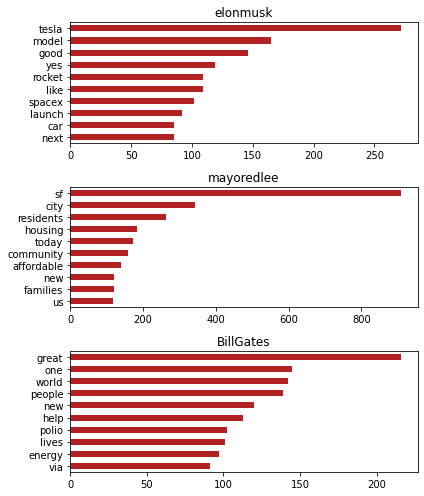

In [40]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout();

Los resultados obtenidos tienen sentido si ponemos en contexto la actividad profesional de los usuarios analizados. Mayor Ed Lee es alcalde de San Francisco (sf), por lo que sus tweets están relacionados con la ciudad, residentes, familias, casas... Elon Musk dirige varias empresas tecnológicas entre las que destacan Tesla y SpaceX, dedicadas a los coches y a la aeronáutica. Por último, Bill Gates, además de propietario de microsoft, dedica parte de su capital a fundaciones de ayuda, de ahí las palabras mundo, polio, ayuda...

### Correlación entre autores

Una forma de cuantificar la similitud entre los perfiles de dos usuarios de Twitter es calculando la correlación en el uso de palabras. La idea es que, si dos usuarios escriben de forma similar, tenderán a utilizar las mismas palabras y con frecuencias similares. La medida de similitud más utilizada al trabajar con texto es 1 - distancia coseno.

Para poder generar los estudios de correlación se necesita disponer de cada variable en una columna. En este caso, las variables a correlacionar son los autores.

In [41]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None
tweets_pivot.head(3)

,BillGates,elonmusk,mayoredlee
token,,,
aa,NaN,16.0,NaN
aaa,NaN,NaN,2.0
aaja,NaN,NaN,2.0


In [42]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.567274,0.496346
elonmusk,0.567274,1.000000,0.276732
mayoredlee,0.496346,0.276732,1.000000


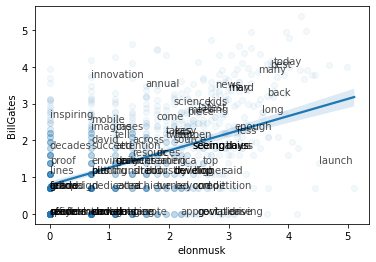

In [51]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elonmusk),
    y  = np.log(temp.BillGates),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.elonmusk[i]), np.log(temp.BillGates[i])),
        alpha = 0.7
    )

In [52]:
# Número de palabras comunes
# ==============================================================================
palabras_elon = set(tweets_tidy[tweets_tidy.autor == 'elonmusk']['token'])
palabras_bill = set(tweets_tidy[tweets_tidy.autor == 'BillGates']['token'])
palabras_edlee = set(tweets_tidy[tweets_tidy.autor == 'mayoredlee']['token'])

print(f"Palabras comunes entre Elon Musk y Ed Lee: {len(palabras_elon.intersection(palabras_edlee))}")
print(f"Palabras comunes entre Elon Elon Musk y Bill Gates: {len(palabras_elon.intersection(palabras_bill))}")

Palabras comunes entre Elon Musk y Ed Lee: 1760
Palabras comunes entre Elon Elon Musk y Bill Gates: 1758


Aunque el número de palabras comunes entre Elon Musk y Bill Gates y entre Elon Musk y Ed Lee es similar, la correlación basada en su uso es mayor entre Elon Musk y Bill Gates. Esto tiene sentido si se contempla el hecho de que ambos trabajan como directivos de empresas tecnológicas.

### Comparación en el uso de palabras

A continuación, se estudia qué palabras se utilizan de forma más diferenciada por cada usuario, es decir, palabras que utiliza mucho un autor y que no utiliza el otro. Una forma de hacer este análisis es mediante el [log of odds ratio](https://en.wikipedia.org/wiki/Odds_ratio) de las frecuencias. Esta comparación se hace por pares, en este caso se comparan Elon Musk y Mayor Ed Lee.

log of odd ratio = log( (nk+1/N+1)Elon / (nk+1/N+1)Edd)

siendo nk el número de veces que aparece el término k en los textos de cada autor y N el número total de términos de cada autor.

Para realizar este cálculo es necesario que, para todos los usuarios, se cuantifique la frecuencia de cada una de las palabras que aparecen en el conjunto de tweets, es decir, si un autor no ha utilizado una de las palabras que sí ha utilizado otro, debe aparecer esa palabra en su registro con frecuencia igual a cero. Existen varias formas de conseguir esto, una de ellas es pivotar y despivotar el dataframe sustituyendo los NaN por cero.